<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Decision Trees
 
_Author: Joseph Nelson (DC)_

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

---

<a id="by-hand"></a>
**Exercise:** Build a Regression Tree by Hand

Your **training data** is a tiny data set of [used vehicle sale prices](https://git.generalassemb.ly/datr1618/lesson15_decision_trees/blob/master/data/vehicles_train.csv). Your goal is to **predict price** for testing data.

**Note:** You wouldn't typically develop a decision tree by hand. The purpose of this exercise is to help develop an understanding of what the computer does when it fits a decision tree.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
vehicle_prices_path = Path('..', 'data', 'vehicles_train.csv')
vehicle_prices = pd.read_csv(vehicle_prices_path)

- Explore the data by sorting, plotting, or performing split-apply-combine (a.k.a. `group_by`). Decide which feature you think is the most important predictor, and use it to create a splitting rule. (Only binary splits are allowed.)

year


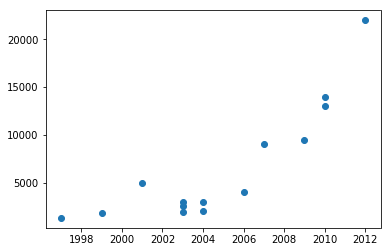

miles


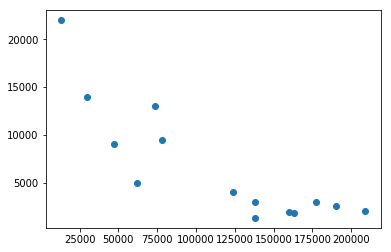

doors


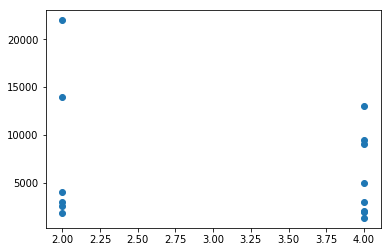

vtype


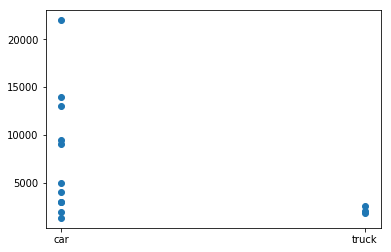

In [3]:
# /scrub/
y = vehicle_prices.loc[:, 'price']
for var in ['year', 'miles', 'doors', 'vtype']:
    print(var)
    x = vehicle_prices.loc[:, var]
    plt.scatter(x, y)
    plt.show()

/scrub/

I am going to split first on year < 2006.5

- Split your DataFrame into two parts corresponding to your first splitting rule. Within each part, decide which feature you think is the most important predictor, and use it to create an additional splitting rule. (You can use the original feature again.)

In [4]:
# /scrub/
vehicle_prices_old = vehicle_prices.loc[vehicle_prices.loc[:, 'year'] < 2006.5, :]
vehicle_prices_new = vehicle_prices.loc[vehicle_prices.loc[:, 'year'] > 2006.5, :]

year


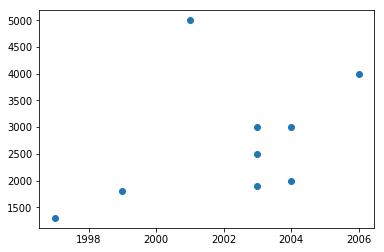

miles


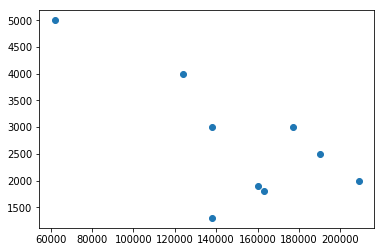

doors


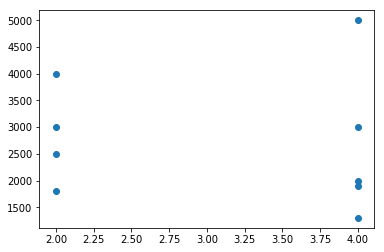

vtype


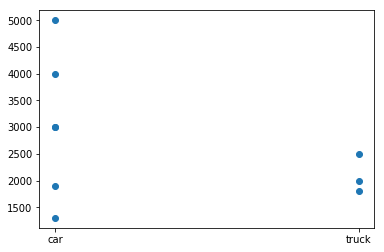

In [5]:
# /scrub/
y = vehicle_prices_old.loc[:, 'price']
for var in ['year', 'miles', 'doors', 'vtype']:
    print(var)
    x = vehicle_prices_old.loc[:, var]
    plt.scatter(x, y)
    plt.show()

/scrub/

For old vehicles, I will split next on car vs. truck.

year


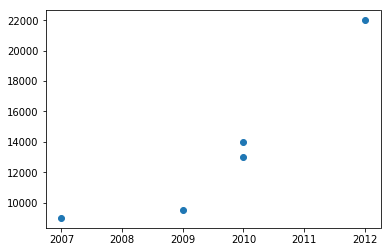

miles


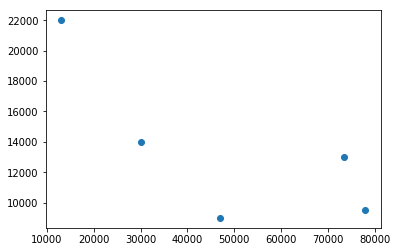

doors


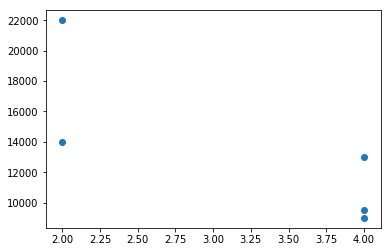

vtype


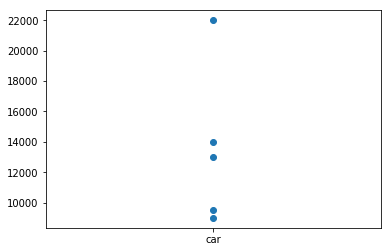

In [6]:
# /scrub/
y = vehicle_prices_new.loc[:, 'price']
for var in ['year', 'miles', 'doors', 'vtype']:
    print(var)
    x = vehicle_prices_new.loc[:, var]
    plt.scatter(x, y)
    plt.show()

/scrub/

For new vehicles, I will split next on doors < 3.

- Draw your tree, labeling the leaves with the mean price for the observations in that region. Make sure nothing is backwards: You follow the **left branch** if the rule is true and the **right branch** if the rule is false.

In [7]:
# /scrub/
print(vehicle_prices_old.loc[vehicle_prices_old.loc[:, 'vtype'] == 'car', 'price'].mean())
print(vehicle_prices_old.loc[vehicle_prices_old.loc[:, 'vtype'] == 'truck', 'price'].mean())
print(vehicle_prices_new.loc[vehicle_prices_new.loc[:, 'doors'] == 2, 'price'].mean())
print(vehicle_prices_new.loc[vehicle_prices_new.loc[:, 'doors'] == 4, 'price'].mean())

3033.3333333333335
2100.0
18000.0
10500.0


/scrub/

![](../assets/vehicle_price_tree.png.jpeg)

<a id="computer-build"></a>
## How Does a Computer Build a Regression Tree?

**Ideal approach:** Consider every possible partition of the feature space.

**Problem:** Too many possibilities to consider.

**"Good enough" approach:** Recursive binary splitting.

1. Begin at the top of the tree.
2. For **every feature**, examine **every possible cutpoint**, and choose the feature and cutpoint so that the resulting tree has the lowest possible mean squared error (MSE). Make that split.
3. Examine the two resulting regions. Once again, make a **single split** (in one of the regions) to minimize the MSE.
4. Keep repeating Step 3 until a **stopping criterion** is met:
    - Maximum tree depth (maximum number of splits required to arrive at a leaf).
    - Minimum number of observations in a leaf.

---

This approach is a **greedy algorithm** because it makes *locally optimal* decisions -- it takes the best split at each step. Greedy algorithms typically are not optimal, but they are often good enough and relatively easy to compute.

**Analogy:**
- Always eating cookies to maximize your immediate happiness (greedy) might not lead to optimal overall happiness.
- In our case, reorganizing parts of the tree already constructed based on future splits might result in a better model overall. 

<a id="cutpoint-demo"></a>
### Demo: Choosing the Ideal Cutpoint for a Given Feature

In [8]:
# Vehicle data
path = Path('..', 'data', 'vehicles_train.csv')
train = pd.read_csv(path)

In [9]:
# Before splitting anything, just predict the mean of the entire data set.
# /scrub/
train.loc[:, 'prediction'] = train.price.mean()
train

,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,6571.428571
1,14000,2010,30000,2,car,6571.428571
2,13000,2010,73500,4,car,6571.428571
3,9500,2009,78000,4,car,6571.428571
4,9000,2007,47000,4,car,6571.428571
5,4000,2006,124000,2,car,6571.428571
6,3000,2004,177000,4,car,6571.428571
7,2000,2004,209000,4,truck,6571.428571
8,3000,2003,138000,2,car,6571.428571
9,1900,2003,160000,4,car,6571.428571


In [10]:
# Calculate RMSE for those predictions.
# /scrub/
from sklearn import metrics
import numpy as np

np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

5936.981985995983

In [11]:
# Define a function that calculates the RMSE for a given split of miles.
# /scrub/
def mileage_split(miles):
    lower_mileage_price = train.loc[train.loc[:, 'miles'] < miles].loc[:, 'price'].mean()
    higher_mileage_price = train.loc[train.loc[:, 'miles'] >= miles].loc[:, 'price'].mean()
    train['prediction'] = (
        np.where(train.loc[:, 'miles'] < miles, lower_mileage_price, higher_mileage_price)
    )
    return np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

In [12]:
# Calculate RMSE for tree that splits on miles < 50,000.
# /scrub/
print('RMSE:', mileage_split(50000))
train

RMSE: 3984.0917425414564


,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,15000.000000
1,14000,2010,30000,2,car,15000.000000
2,13000,2010,73500,4,car,4272.727273
3,9500,2009,78000,4,car,4272.727273
4,9000,2007,47000,4,car,15000.000000
5,4000,2006,124000,2,car,4272.727273
6,3000,2004,177000,4,car,4272.727273
7,2000,2004,209000,4,truck,4272.727273
8,3000,2003,138000,2,car,4272.727273
9,1900,2003,160000,4,car,4272.727273


In [13]:
# Calculate RMSE for tree that splits on miles < 100,000.
# /scrub/
print('RMSE:', mileage_split(100000))
train

RMSE: 3530.146530076269


,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,12083.333333
1,14000,2010,30000,2,car,12083.333333
2,13000,2010,73500,4,car,12083.333333
3,9500,2009,78000,4,car,12083.333333
4,9000,2007,47000,4,car,12083.333333
5,4000,2006,124000,2,car,2437.500000
6,3000,2004,177000,4,car,2437.500000
7,2000,2004,209000,4,truck,2437.500000
8,3000,2003,138000,2,car,2437.500000
9,1900,2003,160000,4,car,2437.500000


In [14]:
# Check all possible mileage splits.
# /scrub/
mileage_range = list(range(train.miles.min(), train.miles.max(), 1000))
RMSE = [mileage_split(miles) for miles in mileage_range]

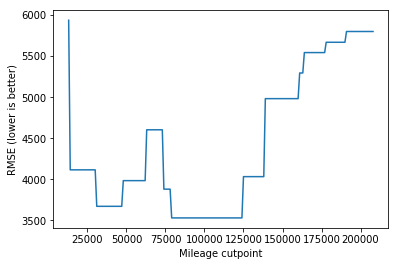

In [15]:
# Plot mileage cutpoint (x-axis) versus RMSE (y-axis).
# /scrub/
plt.plot(mileage_range, RMSE);
plt.xlabel('Mileage cutpoint');
plt.ylabel('RMSE (lower is better)');

**Recap:** Before every split, we repeat this process for every feature and choose the feature and cutpoint that produce the lowest MSE.

<a id="sklearn-tree"></a>
## Building a Regression Tree in `scikit-learn`

In [16]:
# Encode car as 0 and truck as 1.
# /scrub/
train.loc[:, 'vtype'] = train.loc[:, 'vtype'].map({'car':0, 'truck':1})

In [17]:
# Define X and y.
# /scrub/
feature_cols = ['year', 'miles', 'doors', 'vtype']

X = train.loc[:, feature_cols]
y = train.loc[:, 'price']

In [18]:
# Instantiate a DecisionTreeRegressor (with random_state=1).
# /scrub/
from sklearn.tree import DecisionTreeRegressor

treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [19]:
# Use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model.
# /scrub/
from sklearn.model_selection import cross_val_score
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

3107.1428571428573

<a id="too-deep"></a>
## What Happens When We Grow a Tree Too Deep?

- **On the left:** A regression tree for salary that is **grown deeper**.
- **On the right:** A comparison of the **training, testing, and cross-validation errors** for trees with different numbers of leaves.

![Salary tree grown deep](../assets/salary_tree_deep.png)

The **training error** continues to go down as the tree size increases (due to overfitting), but the lowest **cross-validation error** occurs for a tree with a depth of three.

Note that if we make a **complete tree** (where every data point is boxed into its own region), then we will achieve perfect training accuracy. However, then outliers in the training data will greatly affect the model.

<a id="#tuning-tree"></a>
## Tuning a Regression Tree

Let's try to reduce the RMSE by tuning the **max_depth** parameter:

In [20]:
# Try different values one by one.
# /scrub/
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

4050.1443001443

Or, we could write a loop to try a range of values:

In [21]:
# /scrub/

# List of values to try:
max_depth_range = list(range(1, 8))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use LOOCV with each value of max_depth.
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

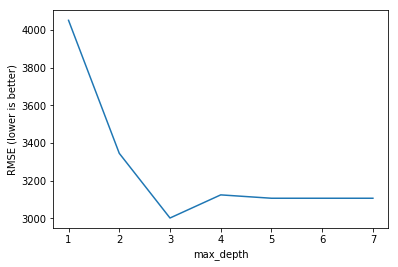

In [22]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
# /scrub/
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [23]:
# max_depth=3 was best, so fit a tree using that parameter.
# /scrub/
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [24]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature.
# /scrub/
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,vtype,0.000000


### Creating a Tree Diagram

To create a tree diagram, we will use the Graphviz library for displaying graph data structures. 

In [25]:
# Create a Graphviz file.
# /scrub/
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='../assets/tree_vehicles.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_vehicles.dot -o tree_vehicles.png

# Or, you can drag the image below to your desktop or Powerpoint!

![Tree for vehicle data](../assets/tree_vehicles.png)

Reading the internal nodes:

- **samples:** Number of observations in that node before splitting.
- **mse:** MSE calculated by comparing the actual response values in that node against the mean response value in that node.
- **rule:** Rule used to split that node (go left if true, go right if false).

Reading the leaves:

- **samples:** Number of observations in that node.
- **value:** Mean response value in that node.
- **mse:** MSE calculated by comparing the actual response values in that node against "value."

<a id="testing-preds"></a>
## Making Predictions for the Testing Data

In [26]:
# Read the testing data.
path = Path('..', 'data', 'vehicles_test.csv')
test = pd.read_csv(path)

In [27]:
# /scrub/
test.loc[:, 'vtype'] = test.loc[:, 'vtype'].map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


**Exercise:** Use the tree diagram above to get the model's prediction for the price of each item in the test set.

- Row 0

/scrub/

4000

- Row 1

/scrub/

5000

- Row 2

/scrub/

13500

**Bonus**: Use the fitted model to check your answers.

In [28]:
# Use fitted model to make predictions on testing data.
# /scrub/
X_test = test.loc[:, feature_cols]
y_test = test.loc[:, 'price']
y_pred = treereg.predict(X_test)

y_pred

array([ 4000.,  5000., 13500.])

In [29]:
# Calculate RMSE
# /scrub/
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1190.2380714238084

In [30]:
# Calculate RMSE for your own tree.
# /scrub/
y_test = [3000, 6000, 12000]
y_pred = [2100, 3033, 18000]

from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

3899.2772407203875

**Exercise.**

- Create a regression tree for the "hitters" data. Train it and get its MSE on the entire data set. Discard any rows with missing salary data.

In [31]:
path = Path('..', 'data', 'hitters.csv')

In [32]:
# /scrub/
hitters = pd.read_csv(path)

In [33]:
# /scrub/
hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [34]:
# /scrub/
hitters = hitters.dropna()

In [35]:
# /scrub/
X = hitters.loc[:, ['Years', 'Hits']]
y = hitters.loc[:, 'Salary']

In [36]:
# /scrub/
dtr = DecisionTreeRegressor()
dtr.fit(X, y)
y_pred = dtr.predict(X)

metrics.mean_squared_error(y, y_pred)

273.8141634980989

- How might discarding rows with missing salary data generate bias? How big of an issue do you think that is in this case? How else could we handle the missing data?

/scrub/

Discarding rows with missing salary data will create bias if that data is not missing completely at random. For instance, it may be that players with greater salaries tend to go to greater lengths to concel those salaries.

This issue could be fairly substantial in this case, because a fairly large proportion of the salaries (~20%) are missing and it is plausible that they are MNAR (missing not at random).

Another option is to **impute** the data, e.g. using the mean or median salaray or inferring the salary from other variables.

- Train your model and calculates its MSE in five-fold cross-validation.

In [37]:
# /scrub/
from sklearn.model_selection import KFold

kf = KFold(5, shuffle=True)

np.mean(-cross_val_score(dtr, X, y, cv=kf, scoring='neg_mean_squared_error'))

228960.38318016025

- **Bonus:** Change your model to reduce cross-validation MSE.

*Possible approaches:*

- Change the `max_depth` of your tree.
- Change [other hyperparameters](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).
- Change the set of features you use.
- Do some "feature engineering:"
    - Dummy-code categorical features to make them usable.
    - Create new features by transforming or combining existing features (e.g. calculate batting averages or other rates). Note that a **monotonic transformation** that doesn't change the orders of the values (e.g. taking a non-negative variable to a power) doesn't make any difference to a decision tree because it can simply move its cutpoints accordingly.

*Advice:*

- Compare training-set performance to test-set performance to decide whether to make your model more or less complicated.
- Plot your data to guide your feature selection and feature engineering efforts.
- Look for natural feature transformations (e.g. calculating rates per at-bat) that might improve both the bias and the variance of your model.

<a id="part-two"></a>
# Part 2: Classification Trees

**Example:** Predict whether Barack Obama or Hillary Clinton will win the Democratic primary in a particular county in 2008 (from the New York Times).

![Obama-Clinton decision tree](../assets/obama_clinton_tree.jpg)

**Exercise:**

- What are the observational units?

/scrub/

Counties

- What is the response variable?

/scrub/

Whether Clinton or Obama won the 2008 primary

- What are the features?

/scrub/

- Percent of population that is black
- High school graduation rate
- Region of the country (south, midwest, west, northeast)
- Percent of households that earned less than $30k
- Population density
- Percentage points by which Bush beat Kerry

- What is the most predictive feature?

/scrub/

Percent of population that is black

- Why does the tree split on high school graduation rate twice in a row?

/scrub/

It makes a three-way split:

- If less than 78 percent, predict Clinton
- If greater than 87 percent, predict Obama
- Between 78 and 87 percent, consider additional variables

- What is the class prediction for the following county: 15 percent African American, 90 percent high school graduation rate, located in the South, high poverty, high population density?

/scrub/

Obama

- What would be the predicted probability for that same county, based on the observed frequency?

In [38]:
# /scrub/
185/(185+36)

0.8371040723981901

<a id="comparing-trees"></a>
## Comparing Regression Trees and Classification Trees

|Regression Trees|Classification Trees|
|---|---|
|Predict a continuous response.|Predict a categorical response.|
|Predict using mean response of each leaf.|Predict using most commonly occurring class of each leaf.|
|Splits are chosen to minimize MSE.|Splits are chosen to minimize Gini index (discussed below).|

<a id="splitting-criteria"></a>
## Splitting Criteria for Classification Trees

Common options for the splitting criteria:

- **Classification error rate:** The fraction of training observations in a region that don't belong to the most common class.
- **Gini index:** The measure of total variance across classes in a region.

### Example: Classification Error Rate

Pretend we are predicting whether or not someone will buy an iPhone or an Android:

- At a particular node, there are **25 observations** (phone buyers) of whom **10 bought iPhones and 15 bought Androids**.
- As the majority class is **Android**, that's our prediction for all 25 observations, and thus the classification error rate is **10/25 = 40%**.

Our goal in making splits is to **reduce the classification error rate**. Let's try splitting on gender:

- **Males:** 2 iPhones and 12 Androids, thus the predicted class is Android.
- **Females:** 8 iPhones and 3 Androids, thus the predicted class is iPhone.
- Classification error rate after this split would be **5/25 = 20%**.

Compare that with a split on age:

- **30 or younger:** 4 iPhones and 8 Androids, thus the predicted class is Android.
- **31 or older:** 6 iPhones and 7 Androids, thus the predicted class is Android.
- Classification error rate after this split would be **10/25 = 40%**.

The decision tree algorithm will try **every possible split across all features** and choose the one that **reduces the error rate the most.**

### Example: Gini Index

Calculate the Gini index before making a split:

$$1 - \left(\frac {iPhone} {Total}\right)^2 - \left(\frac {Android} {Total}\right)^2 = 1 - \left(\frac {10} {25}\right)^2 - \left(\frac {15} {25}\right)^2 = 0.48$$

- The **maximum value** of the Gini index is 0.5 and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of the Gini index is 0 and occurs when there is only one class represented in a node.
- A node with a lower Gini index is said to be more "pure."

Evaluating the split on **gender** using the Gini index:

$$\text{Males: } 1 - \left(\frac {2} {14}\right)^2 - \left(\frac {12} {14}\right)^2 = 0.24$$
$$\text{Females: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{Weighted Average: } 0.24 \left(\frac {14} {25}\right) + 0.40 \left(\frac {11} {25}\right) = 0.31$$

Evaluating the split on **age** using the Gini index:

$$\text{30 or younger: } 1 - \left(\frac {4} {12}\right)^2 - \left(\frac {8} {12}\right)^2 = 0.44$$
$$\text{31 or older: } 1 - \left(\frac {6} {13}\right)^2 - \left(\frac {7} {13}\right)^2 = 0.50$$
$$\text{Weighted Average: } 0.44 \left(\frac {12} {25}\right) + 0.50 \left(\frac {13} {25}\right) = 0.47$$

Again, the decision tree algorithm will try **every possible split** and will choose the one that **reduces the Gini index (and thus increases the "node purity") the most**.

You can think of this as each split increasing the accuracy of predictions. If there is some error at a node, then splitting at that node will result in two nodes with a higher average "node purity" than the original. So, we ensure continually better fits to the training data by continually splitting nodes.

# Classification Error Rate vs. Gini Index

- Gini index is the default in sklearn.
- One advantage Gini index is that it will sometimes make splits that do not improve accuracy but do give better predicted probabilities.

<a id="sklearn-ctree"></a>
## Building a Classification Tree in `scikit-learn`

We'll build a classification tree using the Titanic survival data set:

In [39]:
# Read in the data.
# /scrub/
path = Path('..', 'data', 'titanic.csv')
titanic = pd.read_csv(path)

In [40]:
# Encode female as 0 and male as 1.
# /scrub/
titanic.loc[:, 'Sex'] = titanic.loc[:, 'Sex'].map({'female':0, 'male':1})

In [41]:
# Fill in the missing values for age with the median age.
# /scrub/
titanic.loc[:, 'Age'].fillna(titanic.loc[:, 'Age'].median(), inplace=True)

In [42]:
# Create a DataFrame of dummy variables for Embarked.
# /scrub/
embarked_dummies = pd.get_dummies(titanic.loc[:, 'Embarked'], prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

In [43]:
# Concatenate the original DataFrame and the dummy DataFrame.
# /scrub/
titanic = pd.concat([titanic, embarked_dummies], axis=1)

In [44]:
# Print the updated DataFrame.
# /scrub/
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1


- **Survived:** 0=died, 1=survived (response variable)
- **Pclass:** 1=first class, 2=second class, 3=third class
    - What will happen if the tree splits on this feature?
- **Sex:** 0=female, 1=male
- **Age:** Numeric value
- **Embarked:** C or Q or S

In [45]:
# Define X and y.
# /scrub/
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']

X = titanic.loc[:, feature_cols]
y = titanic.loc[:, 'Survived']

In [46]:
# Fit a classification tree with max_depth=3 on all data.
# /scrub/
from sklearn.tree import DecisionTreeClassifier

treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [47]:
# Create a Graphviz file.
# /scrub/
export_graphviz(treeclf, out_file='../assets/tree_titanic.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

# Or, just drag this image to your desktop or Powerpoint.

![Tree for Titanic data](../assets/tree_titanic.png)

Notice the split in the bottom right; the **same class** is predicted in both of its leaves. That split didn't affect the **classification error rate**, although it did increase the **node purity**. This is important because it increases the accuracy of our predicted probabilities.

A useful side effect of measures such as the Gini index is that they can be used give some indication of feature importance:

In [48]:
# Compute the feature importances (total reduction of Gini index brought by that feature)
# /scrub/
pd.DataFrame({'feature': feature_cols, 'importance': treeclf.feature_importances_})

,feature,importance
0,Pclass,0.242664
1,Sex,0.655584
2,Age,0.064494
3,Embarked_Q,0.000000
4,Embarked_S,0.037258


<a id="part-three"></a>
# Summary: Comparing Decision Trees With Other Models

**Advantages of decision trees:**

- They can be used for regression or classification.
- They can be displayed graphically.
- They are highly interpretable.
- They can be specified as a series of rules, and more closely approximate human decision-making than other models.
- Prediction is fast.
- Their features don't need scaling.
- They automatically learn feature interactions.
- Tends to ignore irrelevant features.
- They are non-parametric -- as a result, they will outperform linear models if the relationship between features and response is highly non-linear.

Logistic regression on $X_1$ and $X_2$ yields a straight-line decision boundary, while a decision tree yields boxes. Which one is better depends on the relationship between the features and the response:

- Left: Logistic regression decision boundary
- Right: Decision tree decision boundary

Green and yellow indicate the true classes.

![Trees versus linear models](../assets/tree_vs_linear.png)

**Disadvantages of decision trees:**

- Their performance is (generally) not competitive with the best supervised learning methods.
- They can easily overfit the training data (tuning is required).
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree.
- They don't tend to work well if the classes are highly unbalanced.
- They don't tend to work well with very small data sets.

# Questions?

# [Exit Tickets](https://goo.gl/forms/bJuNA1LpN2goAYmT2)

### BONUS
Other splitting criteria to look into (for classification trees)
- [entropy](https://bricaud.github.io/personal-blog/entropy-in-decision-trees/)
- [information gain ratio](https://www3.nd.edu/~rjohns15/cse40647.sp14/www/content/lectures/23%20-%20Decision%20Trees%202.pdf)